This project uses the **VocalFolds** dataset. It comprises a set of images and segmentation masks.
 
All images in the dataset are of size 512x512.

For more information about the dataset, visit https://github.com/imesluh/vocalfolds.

Code borrowed from this car segmentation example at
https://github.com/qubvel/segmentation_models.pytorch/tree/master/examples and modified.

For more information on the segmentation model used here, visit this
github page at https://github.com/qubvel/segmentation_models.pytorch 



## Installing pytorch and data augmentation packages

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-_7me2_do
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-_7me2_do
  Created wheel for albumentations: filename=albumentations-0.5.2-cp36-none-any.whl size=72232 sha256=927c267c3aba6c2a44683db25d858d677f2e5bffe1248978ea838b17cfa2a493
  Stored in directory: /tmp/pip-ephem-wheel-cache-xhuniuem/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


## Loading data

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
#If using google colab to run this notebook

#Load vocal folds dataset from github
!git clone https://github.com/imesluh/vocalfolds
%cd vocalfolds

Cloning into 'vocalfolds'...
remote: Enumerating objects: 1181, done.
remote: Total 1181 (delta 0), reused 0 (delta 0), pack-reused 1181
Receiving objects: 100% (1181/1181), 204.46 MiB | 45.67 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/vocalfolds


In [ ]:
#Load images and associated masks

img_dir= './img/'
mask_dir = './annot/'
img = os.path.join(img_dir, 'patient2/seq8')
mask = os.path.join(mask_dir, 'patient2/seq8')




In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Helper class for data extraction, transformation and preprocessing  
https://pytorch.org/docs/stable/data

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms, utils, datasets, models

In [ ]:
class Dataset(BaseDataset):
    """VocalFolds Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['void', 'vocal folds', 'other tissue', 'glottal space', 'pathology', 
               'surgical tool', 'intubation']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

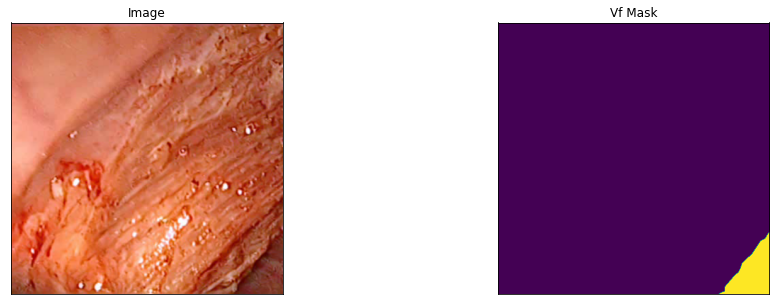

In [ ]:
# Lets look at data we have

original_dataset = Dataset(img, mask, classes=['glottal space'])

image, mask = original_dataset[1] # get some sample
visualize(
    image=image, 
    vf_mask=mask.squeeze(),
)

### Augmentations

Since the dataset is very small, a large number of different augmentations will be applied:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

The transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [ ]:
import albumentations as albu

In [ ]:
def get_augmentation():
    data_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(data_transform)



def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

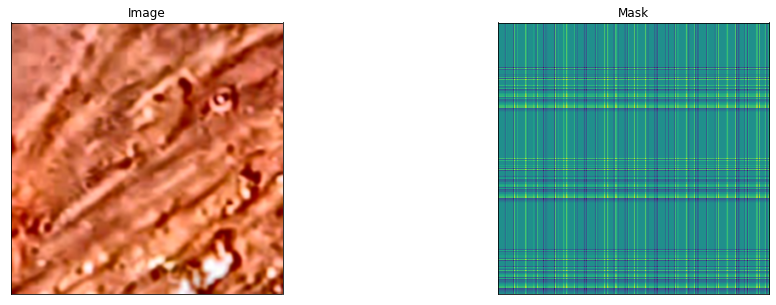

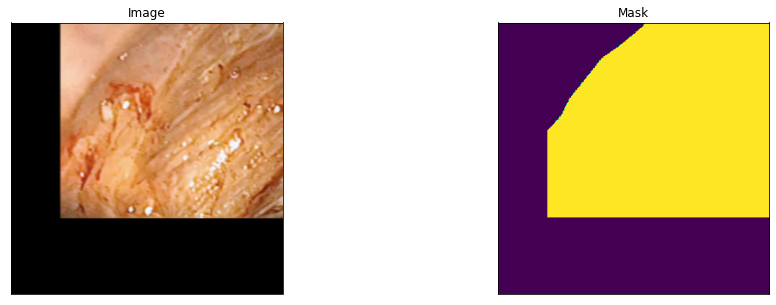

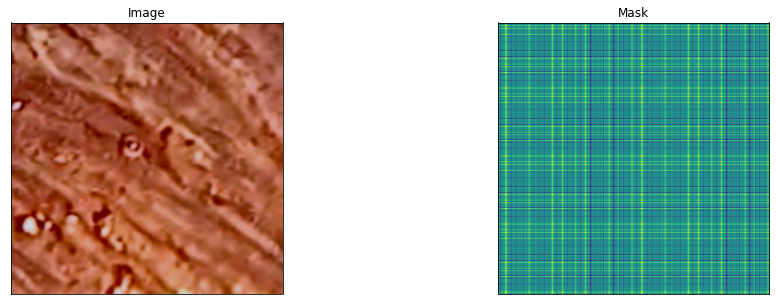

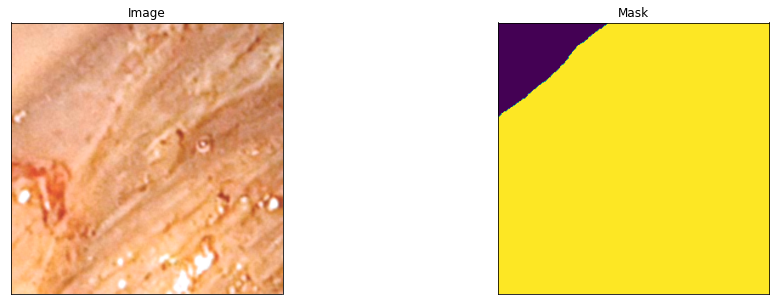

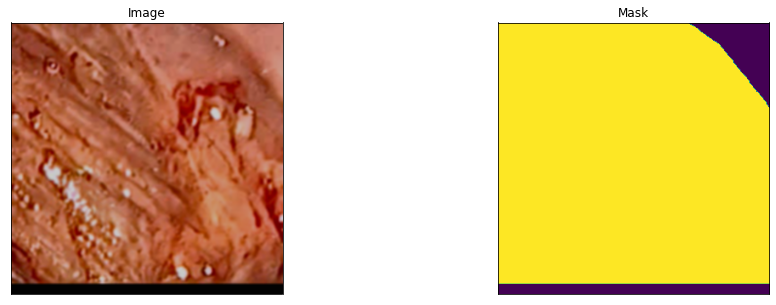

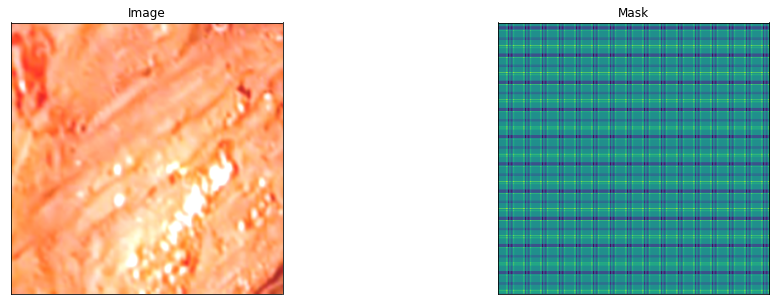

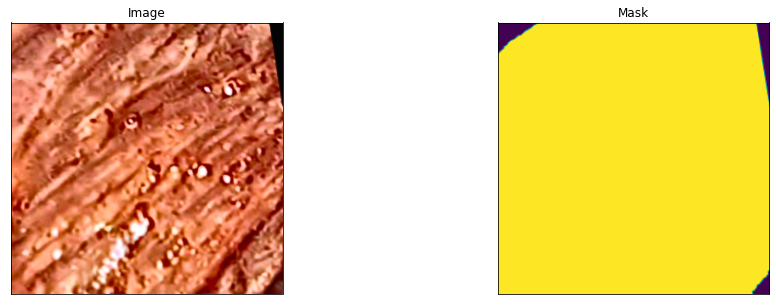

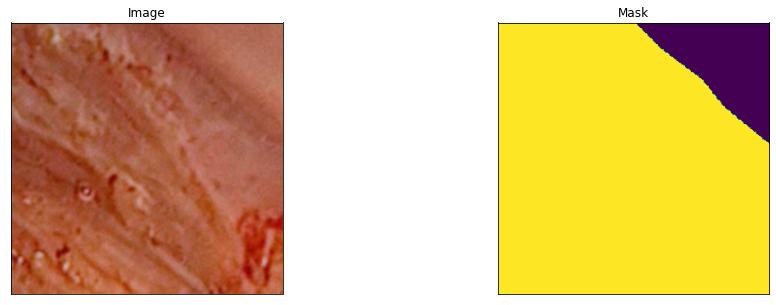

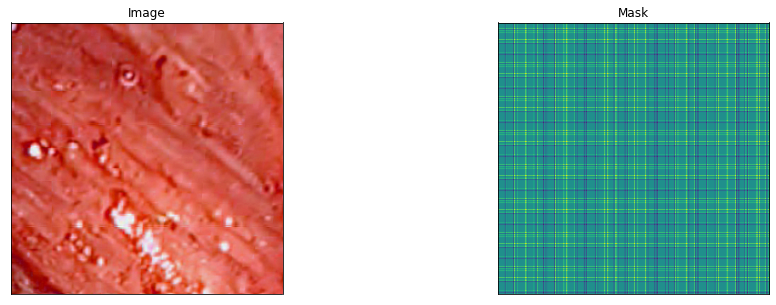

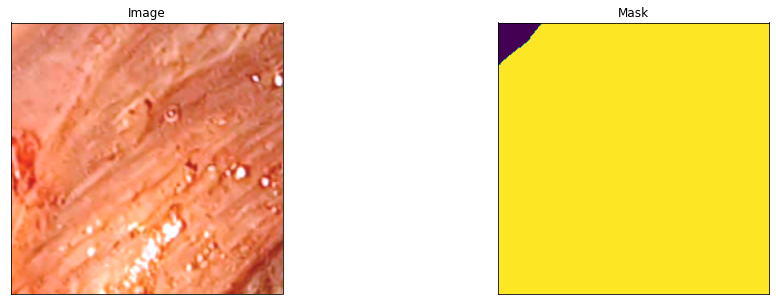

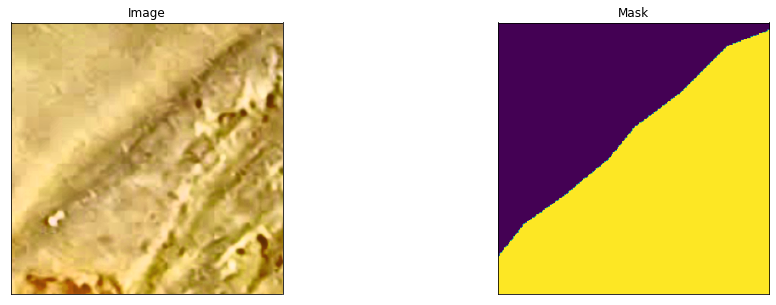

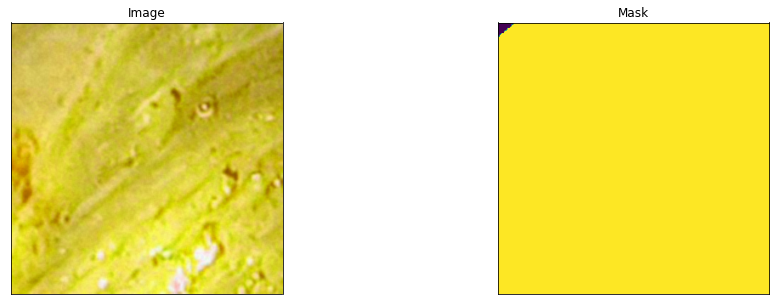

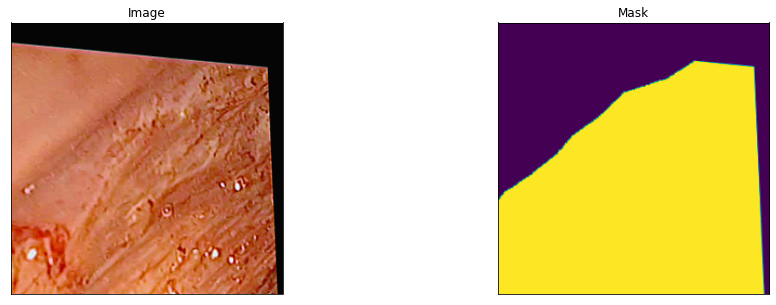

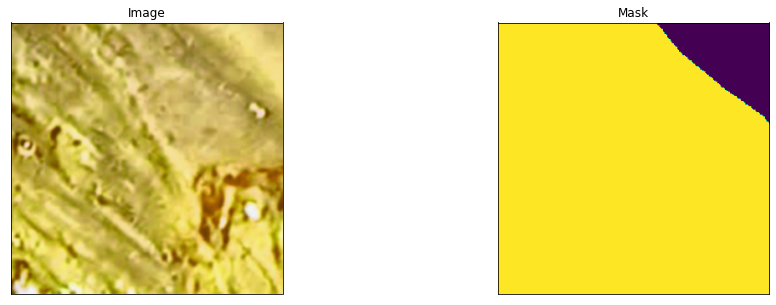

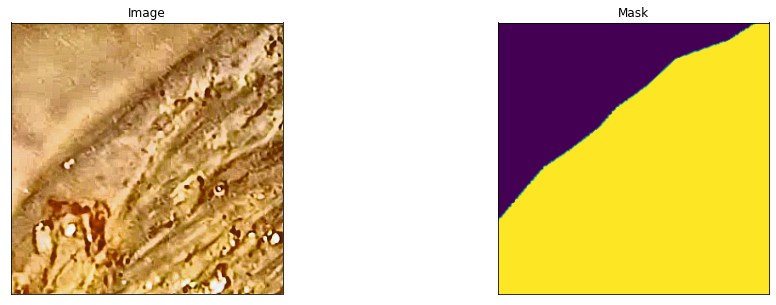

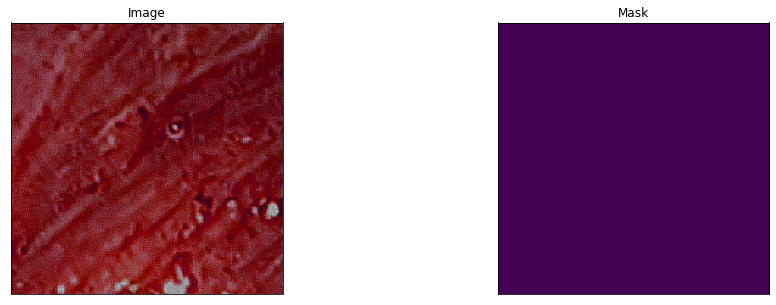

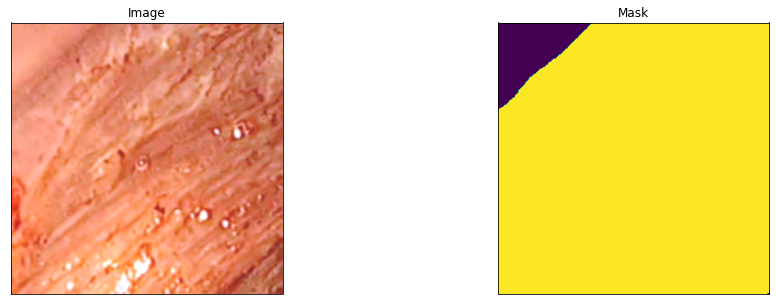

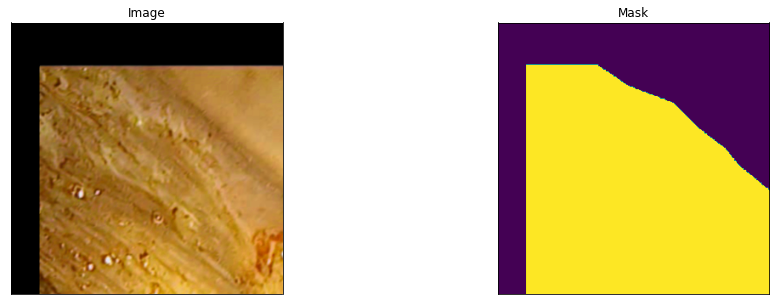

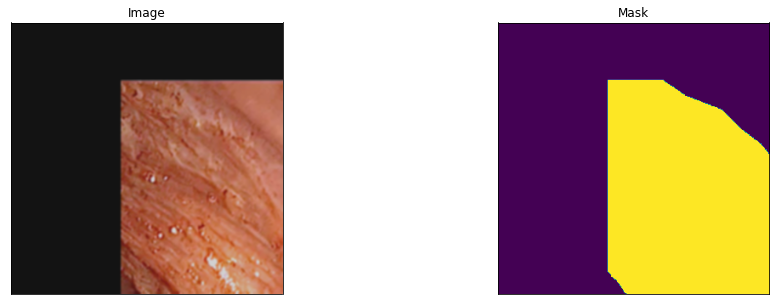

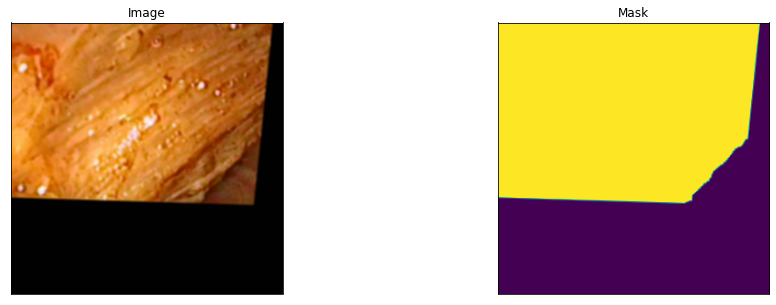

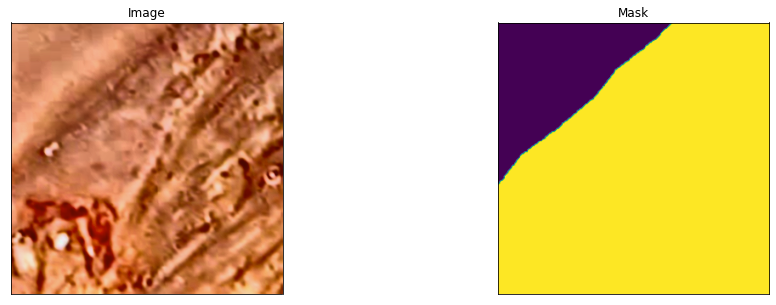

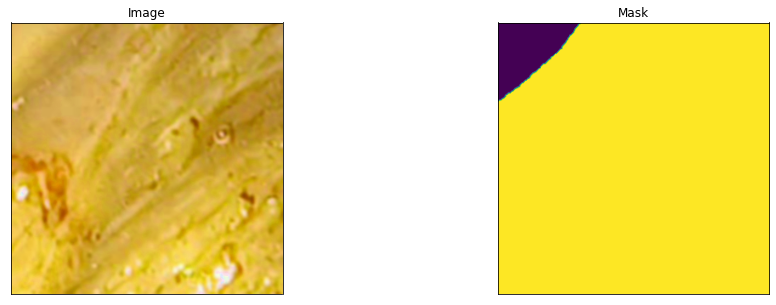

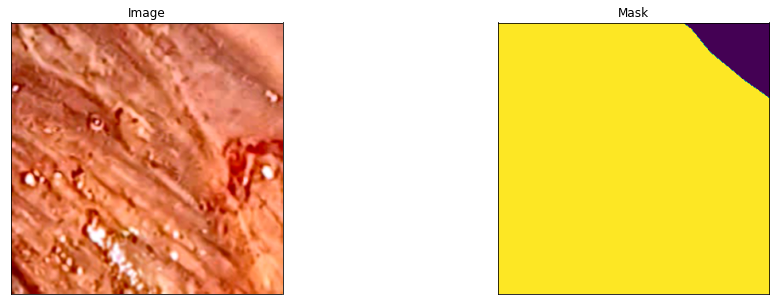

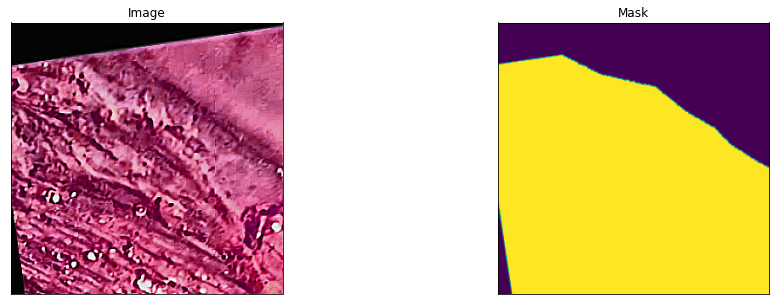

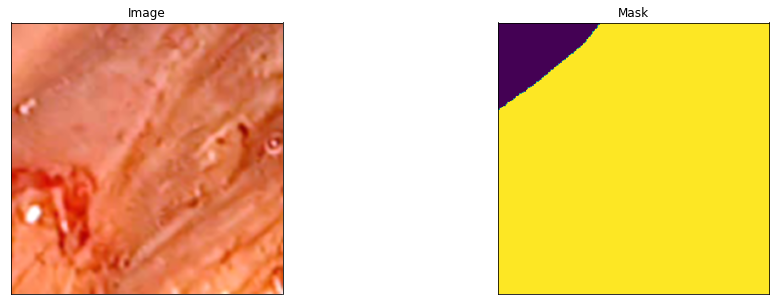

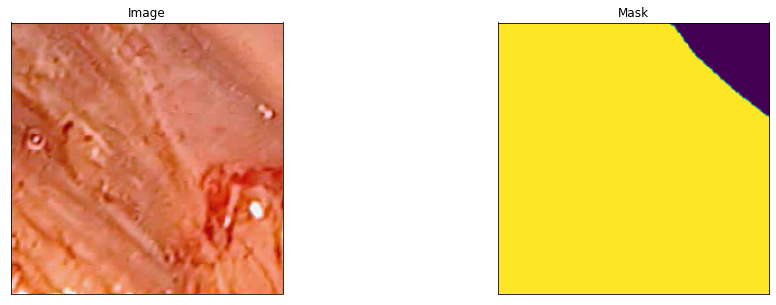

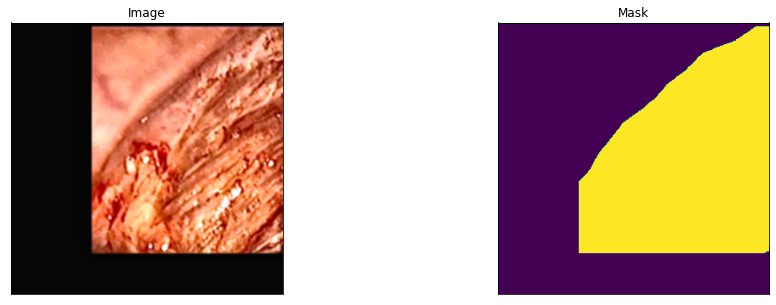

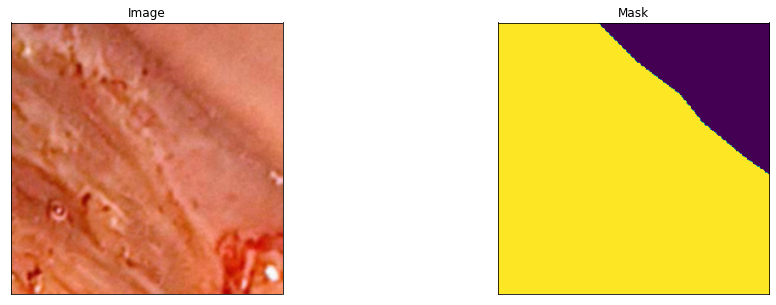

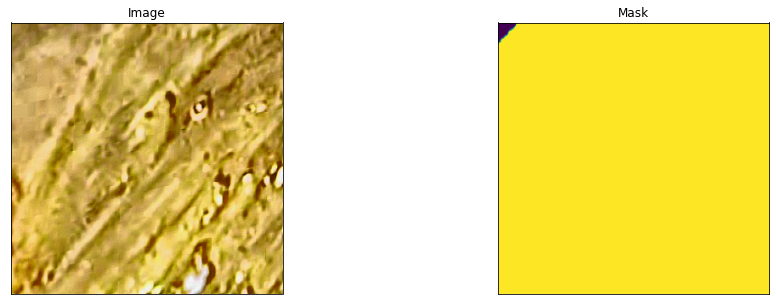

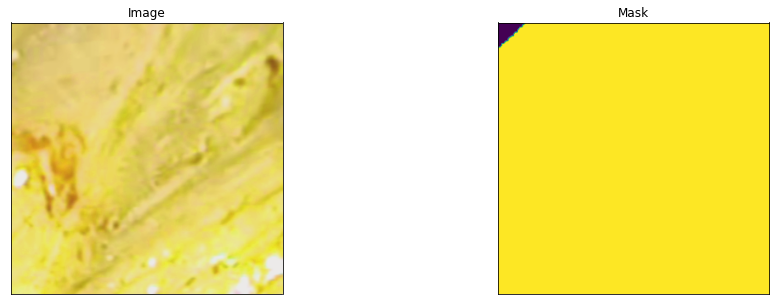

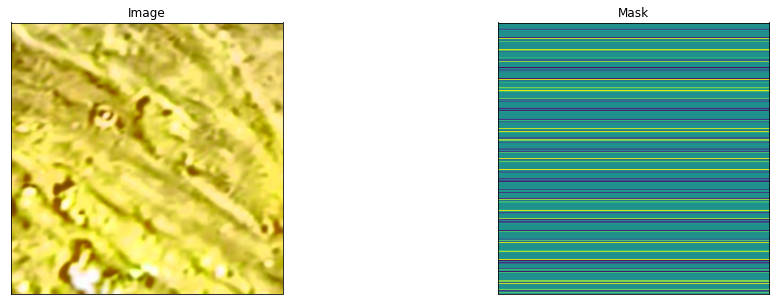

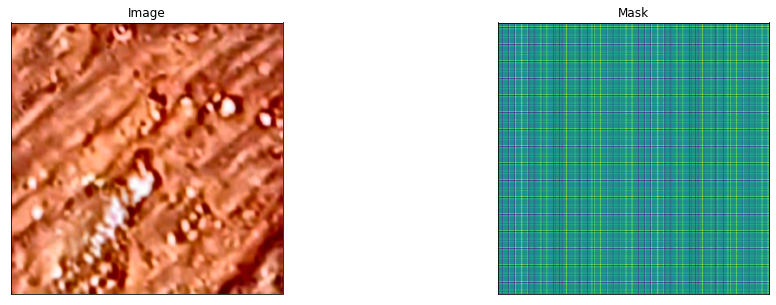

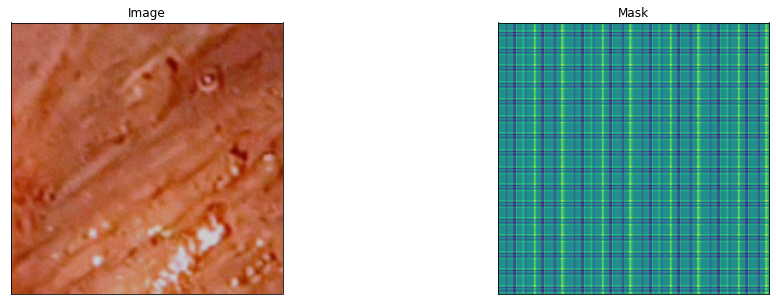

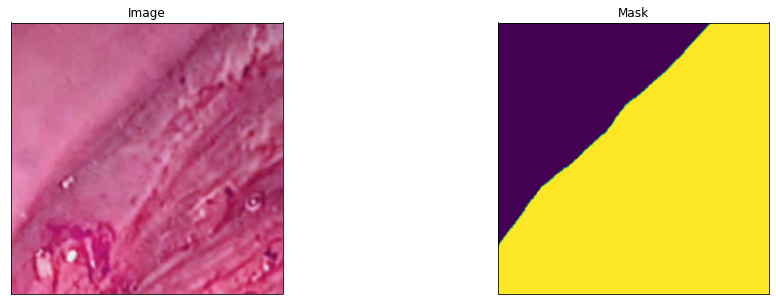

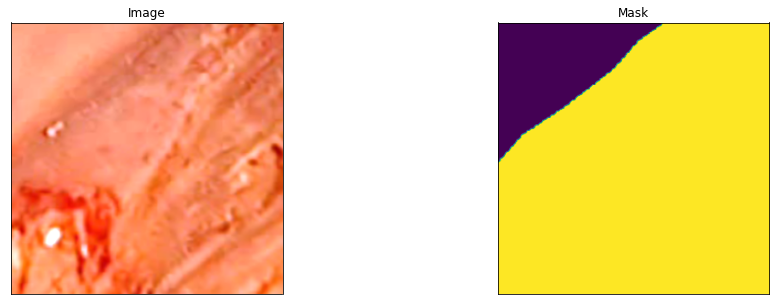

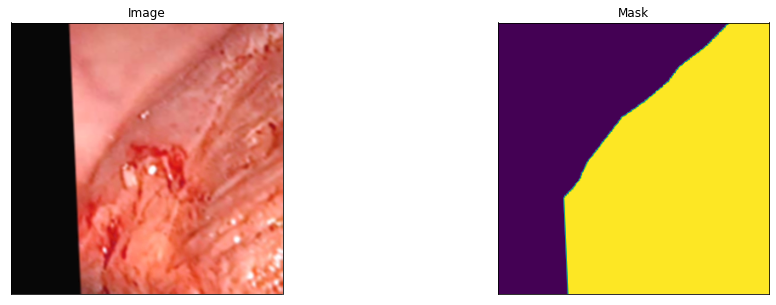

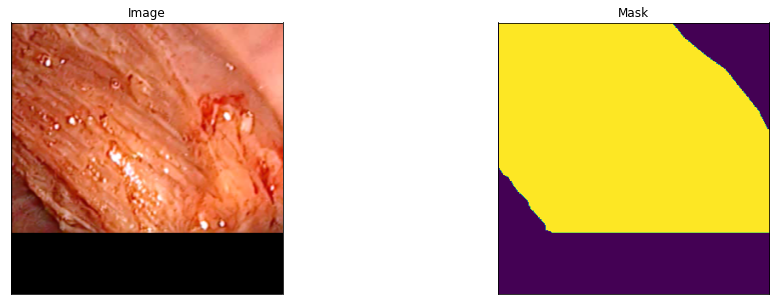

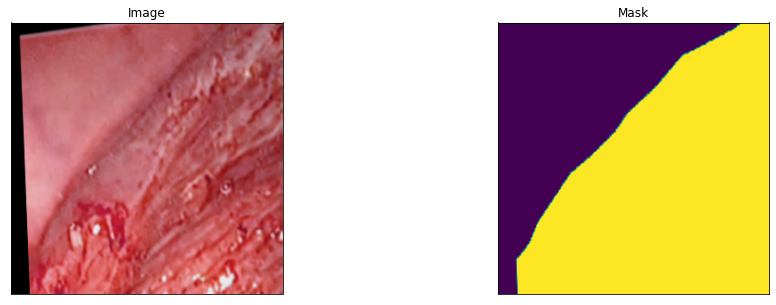

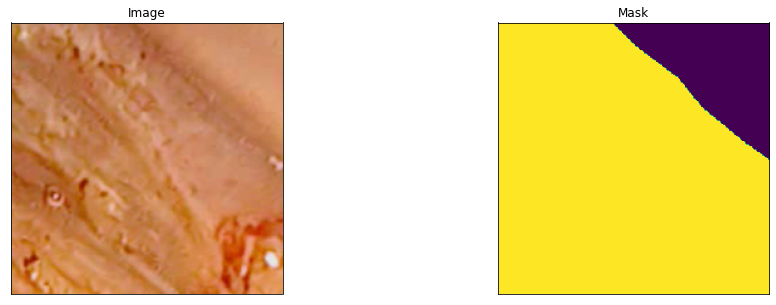

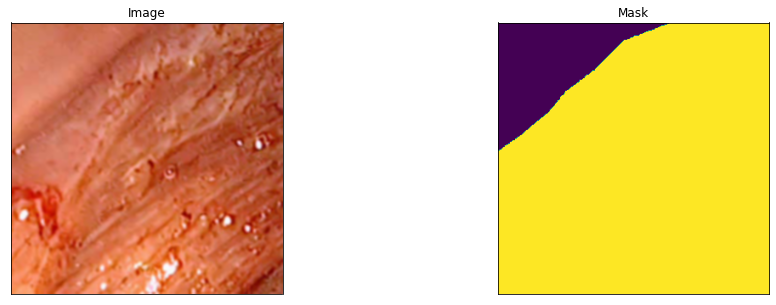

In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(img, mask, classes=['vocal folds'],augmentation=get_augmentation())

# same image with different random transforms
for i in range(40):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## Create and train model 

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['void', 'vocal folds', 'other tissue', 'glottal space', 'pathology', 
               'surgical tool', 'intubation']
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
#Split dataset into train, validation and test sets
dataset = Dataset(
                  img, 
                  mask,                 
                  augmentation=get_augmentation(), 
                  preprocessing=get_preprocessing(preprocessing_fn),
                  classes=CLASSES,
)



In [ ]:
n_train = int(0.7 * len(dataset)) 
n_val = int(0.2 * len(dataset))
n_test = len(dataset) - n_train - n_val
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, (n_train, n_val, n_test))



In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=8)

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device = DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device = DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 37/37 [00:03<00:00, 10.66it/s, dice_loss - 0.3801, iou_score - 0.5642]
Model saved!

Epoch: 1
valid: 100%|██████████| 37/37 [00:03<00:00, 10.55it/s, dice_loss - 0.3821, iou_score - 0.5735]
Model saved!

Epoch: 2
valid: 100%|██████████| 37/37 [00:03<00:00, 10.73it/s, dice_loss - 0.3643, iou_score - 0.5752]
Model saved!

Epoch: 3
valid: 100%|██████████| 37/37 [00:03<00:00, 10.63it/s, dice_loss - 0.3049, iou_score - 0.6258]
Model saved!

Epoch: 4
valid: 100%|██████████| 37/37 [00:03<00:00, 10.64it/s, dice_loss - 0.2918, iou_score - 0.6515]
Model saved!

Epoch: 5
valid: 100%|██████████| 37/37 [00:03<00:00, 11.27it/s, dice_loss - 0.2872, iou_score - 0.644]

Epoch: 6
valid: 100%|██████████| 37/37 [00:03<00:00, 11.32it/s, dice_loss - 0.2762, iou_score - 0.6416]

Epoch: 7
valid: 100%|██████████| 37/37 [00:03<00:00, 10.75it/s, dice_loss - 0.259, iou_score - 0.7375]
Model saved!

Epoch: 8
valid: 100%|██████████| 37/37 [00:03<00:00, 10.68it/s, dice_loss - 0.2282,

## Test model

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 19/19 [00:01<00:00, 10.53it/s, dice_loss - 0.1111, iou_score - 0.889]


## Citation

@misc{Yakubovskiy:2019,
  Author = {Pavel Yakubovskiy},
  Title = {Segmentation Models Pytorch},
  Year = {2020},
  Publisher = {GitHub},
  Journal = {GitHub repository},
  Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
}


